# IF3270 Machine Learning | Praktikum

This notebook serves as a template for the assignment. Please create a copy of this notebook to complete your work. You can add more code blocks, markdown blocks, or new sections if needed.


Group Number: xx

Group Members:
- Name (NIM)
- Name (NIM)

## Import Libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier, 
    VotingClassifier, 
    StackingClassifier
)
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

## Import Dataset

In [25]:
# Train
url = "Train_processed.csv"
# Test
url_test = "test_processed_no_solution.csv"

train_df = pd.read_csv(url)
test_df = pd.read_csv(url_test)

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Training data shape: (5647, 11)
Test data shape: (2421, 10)


# 1. Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a crucial step in the data analysis process that involves examining and visualizing data sets to uncover patterns, trends, anomalies, and insights. It is the first step before applying more advanced statistical and machine learning techniques. EDA helps you to gain a deep understanding of the data you are working with, allowing you to make informed decisions and formulate hypotheses for further analysis. Provide at least 3 analysis

In [26]:
train_df.isnull().sum()

ID                   0
Gender               0
Ever_Married        84
Age                  0
Graduated           40
Profession          79
Work_Experience    562
Spending_Score       0
Family_Size        224
Var_1               53
Segmentation         0
dtype: int64

In [27]:
train_df.describe()

,ID,Age,Work_Experience,Family_Size
count,5647.000000,5647.000000,5085.000000,5423.000000
mean,463474.687799,43.663538,2.654277,2.861147
std,2598.820204,16.779417,3.429239,1.536501
min,458982.000000,16.000000,0.000000,1.000000
25%,461248.500000,30.000000,0.000000,2.000000
50%,463468.000000,41.000000,1.000000,3.000000
75%,465754.500000,53.000000,4.000000,4.000000
max,467974.000000,91.000000,14.000000,9.000000


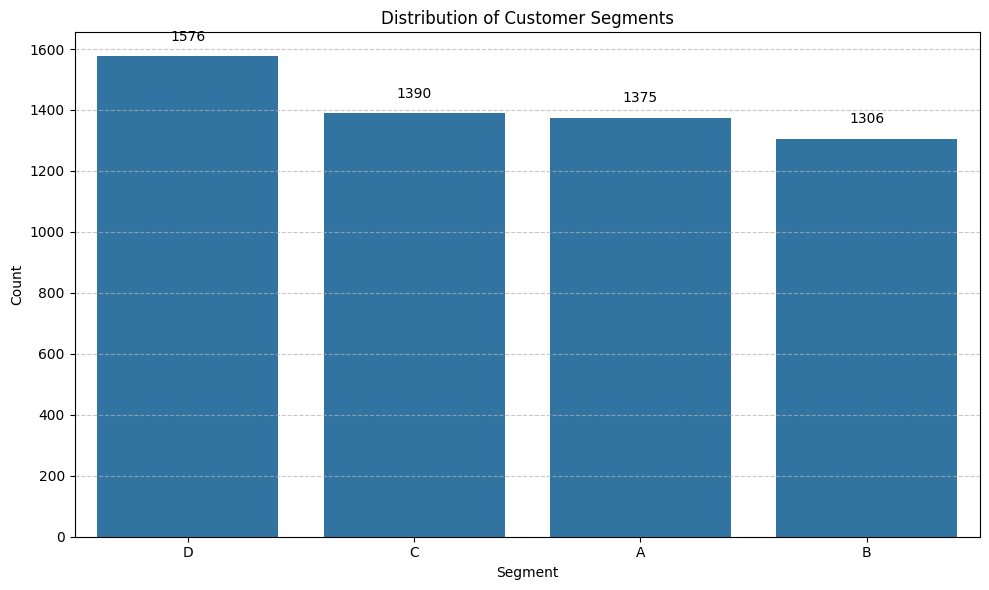

Segment distribution percentage:
Segment D: 27.91%
Segment C: 24.61%
Segment A: 24.35%
Segment B: 23.13%


In [28]:
plt.figure(figsize=(10, 6))
segment_counts = train_df['Segmentation'].value_counts()
sns.barplot(x=segment_counts.index, y=segment_counts.values)
plt.title('Distribution of Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, count in enumerate(segment_counts.values):
    plt.text(i, count + 50, str(count), ha='center')

plt.tight_layout()
plt.show()

print("Segment distribution percentage:")
segment_percentage = segment_counts / len(train_df) * 100
for segment, percentage in segment_percentage.items():
    print(f"Segment {segment}: {percentage:.2f}%")

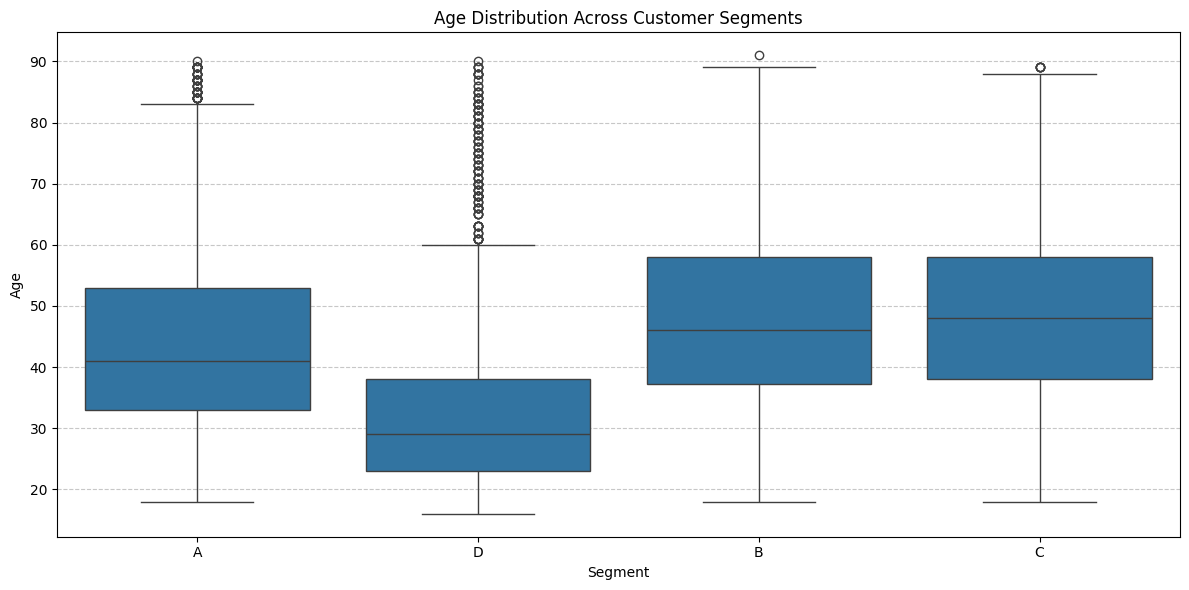

Age statistics by segment:
                   mean  median  min  max
Segmentation                             
A             45.368727    41.0   18   90
B             48.356049    46.0   18   91
C             49.055396    48.0   18   89
D             33.531726    29.0   16   90


In [29]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Segmentation', y='Age', data=train_df)
plt.title('Age Distribution Across Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Age')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

segment_age_stats = train_df.groupby('Segmentation')['Age'].agg(['mean', 'median', 'min', 'max'])
print("Age statistics by segment:")
print(segment_age_stats)

<Figure size 1000x600 with 0 Axes>

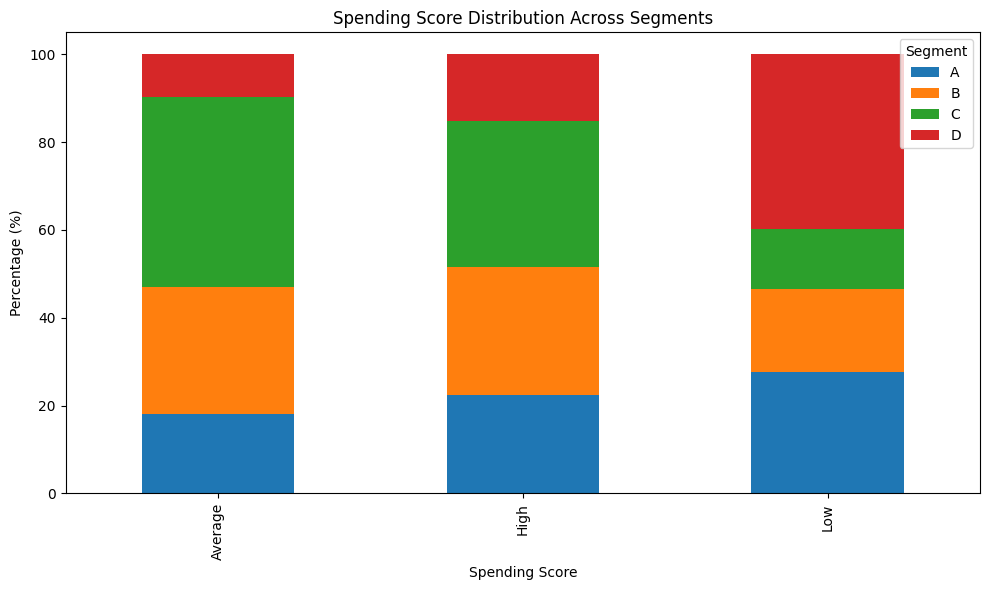

Spending Score counts by segment:
Segmentation      A    B    C     D
Spending_Score                     
Average         260  418  627   140
High            214  277  316   145
Low             901  611  447  1291


In [30]:
plt.figure(figsize=(10, 6))
spending_segment = pd.crosstab(train_df['Spending_Score'], train_df['Segmentation'], normalize='index') * 100
spending_segment.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Spending Score Distribution Across Segments')
plt.xlabel('Spending Score')
plt.ylabel('Percentage (%)')
plt.legend(title='Segment')
plt.tight_layout()
plt.show()

# Show absolute counts
spending_counts = pd.crosstab(train_df['Spending_Score'], train_df['Segmentation'])
print("Spending Score counts by segment:")
print(spending_counts)

# 2. Split Training Set and Validation Set

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. If you want to use k-fold cross-validation, split the data later and do the cleaning and preprocessing separately for each split.

Note: For training, you should use the data contained in the `Train_processed.csv` given by the TA. The `test_processed_no_solution.csv` data is only used for kaggle submission.

In [31]:
# Features and target variable
X = train_df.drop('Segmentation', axis=1)
y = train_df['Segmentation']

# Keep original dataset for later use
original_X = X.copy()
original_y = y.copy()

# Split into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")

Training set shape: (4517, 10), Validation set shape: (1130, 10)


# 3. Data Cleaning and Preprocessing

This step is the first thing to be done once a Data Scientist have grasped a general knowledge of the data. Raw data is **seldom ready for training**, therefore steps need to be taken to clean and format the data for the Machine Learning model to interpret.

By performing data cleaning and preprocessing, you ensure that your dataset is ready for model training, leading to more accurate and reliable machine learning results. These steps are essential for transforming raw data into a format that machine learning algorithms can effectively learn from and make predictions.

For each step that you will do, **please explain the reason why did you do that process. Write it in a markdown cell under the code cell you wrote.**

In [42]:
# Define preprocessing for numerical features (Age, Work_Experience, Family_Size)
numerical_features = ['Age', 'Work_Experience', 'Family_Size']

# Function to handle outliers using Quantile-Based Flooring and Capping
def handle_outliers(X):
    X = X.copy()
    for col in numerical_features:
        lower_bound = X[col].quantile(0.05)
        upper_bound = X[col].quantile(0.95)
        X[col] = X[col].clip(lower=lower_bound, upper=upper_bound)  # Apply capping
    return X

outlier_transformer = FunctionTransformer(handle_outliers, validate=False)

numerical_transformer = Pipeline(steps=[
    ('outlier_handler', outlier_transformer),  # Handle outliers
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values
    ('scaler', StandardScaler())  # Scale the data
])

categorical_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Compile Preprocessing Pipeline

All of the preprocessing classes or functions defined earlier will be compiled in this step.

If you use sklearn to create preprocessing classes, you can list your preprocessing classes in the Pipeline object sequentially, and then fit and transform your data.

In [43]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Drop ID column
)

or create your own here

# 4. Modeling and Validation

Modelling is the process of building your own machine learning models to solve specific problems, or in this assignment context, predicting the probability for each class in the `Segmentation` feature. Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

In this task, you are required to predict each class in the Segmentation feature using Ensemble Learning algorithms.

## 4.1 Ensemble

Implement **at least 1 model** for each of the following learning algorithms:

- Bagging
- Boosting
- Stacking
- Voting

### 4.1.1 Bagging
Bagging is a technique that trains a single type of model, with each model being trained on a different subset of the data. The final prediction is determined by the most frequently occurring prediction across all models. As a reference, you may use `RandomForestClassifier` to build your bagging model.

Random Forest (Bagging) - Macro F1 Score: 0.4554

Classification Report (Random Forest):
              precision    recall  f1-score   support

           A       0.38      0.37      0.37       275
           B       0.37      0.31      0.34       261
           C       0.48      0.50      0.49       278
           D       0.59      0.66      0.62       316

    accuracy                           0.47      1130
   macro avg       0.45      0.46      0.46      1130
weighted avg       0.46      0.47      0.46      1130



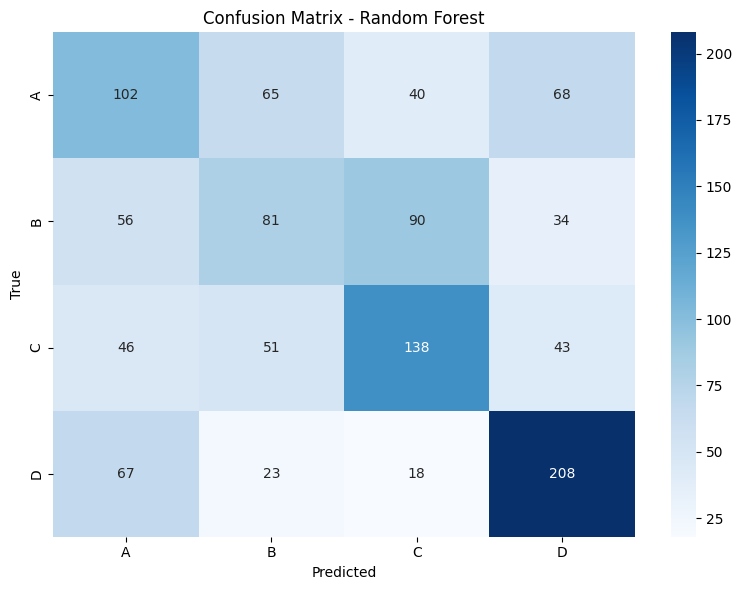

In [44]:
rf_classifier = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_classifier.predict(X_val)

# Evaluate the model
rf_f1_macro = f1_score(y_val, rf_predictions, average='macro')
print(f"Random Forest (Bagging) - Macro F1 Score: {rf_f1_macro:.4f}")

# Display classification report
print("\nClassification Report (Random Forest):")
print(classification_report(y_val, rf_predictions))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, rf_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


### 4.1.2 Boosting
Boosting is a technique where the first model is trained on entire dataset, the second model to reduce the error of first model, followed by a third model to reduce the error of the second model, and so on. As a reference, you may use `GradientBoostingClassifier` to build your boosting model.

Gradient Boosting - Macro F1 Score: 0.4998

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

           A       0.46      0.41      0.43       275
           B       0.39      0.33      0.36       261
           C       0.55      0.57      0.56       278
           D       0.60      0.72      0.65       316

    accuracy                           0.52      1130
   macro avg       0.50      0.51      0.50      1130
weighted avg       0.50      0.52      0.51      1130



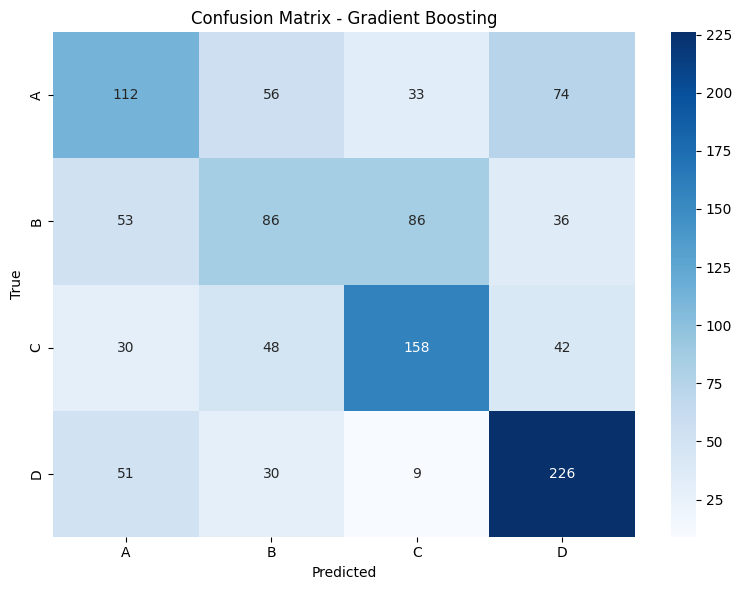

In [45]:
gb_classifier = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

# Train the model
gb_classifier.fit(X_train, y_train)

# Make predictions
gb_predictions = gb_classifier.predict(X_val)

# Evaluate the model
gb_f1_macro = f1_score(y_val, gb_predictions, average='macro')
print(f"Gradient Boosting - Macro F1 Score: {gb_f1_macro:.4f}")

# Display classification report
print("\nClassification Report (Gradient Boosting):")
print(classification_report(y_val, gb_predictions))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, gb_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

XGB - Macro F1 Score: 0.4853

Classification Report (XGB):
              precision    recall  f1-score   support

           A       0.43      0.40      0.41       275
           B       0.39      0.32      0.35       261
           C       0.55      0.57      0.56       278
           D       0.57      0.67      0.62       316

    accuracy                           0.50      1130
   macro avg       0.48      0.49      0.49      1130
weighted avg       0.49      0.50      0.49      1130



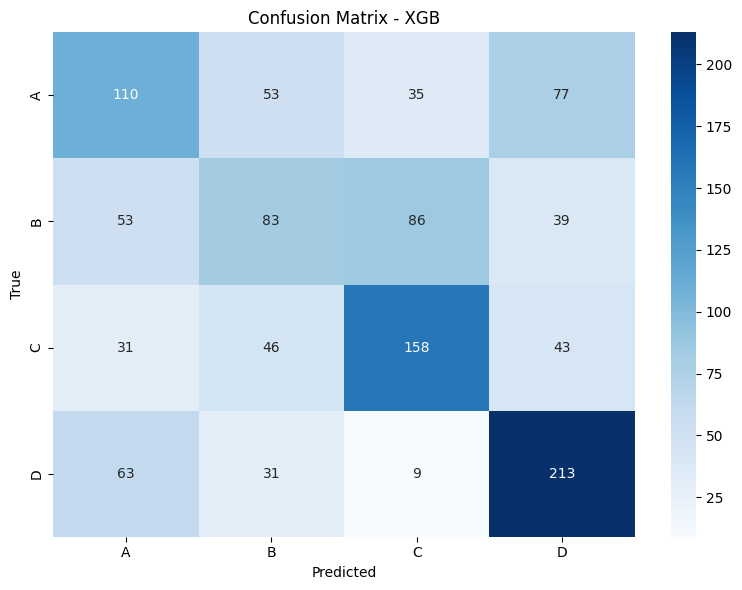

In [46]:
xgb_classifier = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
])

# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)  # Transform validation labels too

# Train the model
xgb_classifier.fit(X_train, y_train_encoded)

# Make predictions
xgb_predictions = xgb_classifier.predict(X_val)
xgb_predictions_decoded = label_encoder.inverse_transform(xgb_predictions)

# Evaluate the model
xgb_f1_macro = f1_score(y_val, xgb_predictions_decoded, average='macro')
print(f"XGB - Macro F1 Score: {xgb_f1_macro:.4f}")

# Display classification report
print("\nClassification Report (XGB):")
print(classification_report(y_val, xgb_predictions_decoded))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, xgb_predictions_decoded)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix - XGB')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

### 4.1.3 Voting
Voting is a technique that trains multiple different models, with each model being trained on the entire dataset. The final prediction is obtained through voting. As a reference, you may use `VotingClassifier` to build your voting model.

Voting Classifier - Macro F1 Score: 0.4755

Classification Report (Voting Classifier):
              precision    recall  f1-score   support

           A       0.41      0.41      0.41       275
           B       0.39      0.26      0.31       261
           C       0.51      0.56      0.53       278
           D       0.59      0.71      0.65       316

    accuracy                           0.50      1130
   macro avg       0.48      0.48      0.48      1130
weighted avg       0.48      0.50      0.48      1130



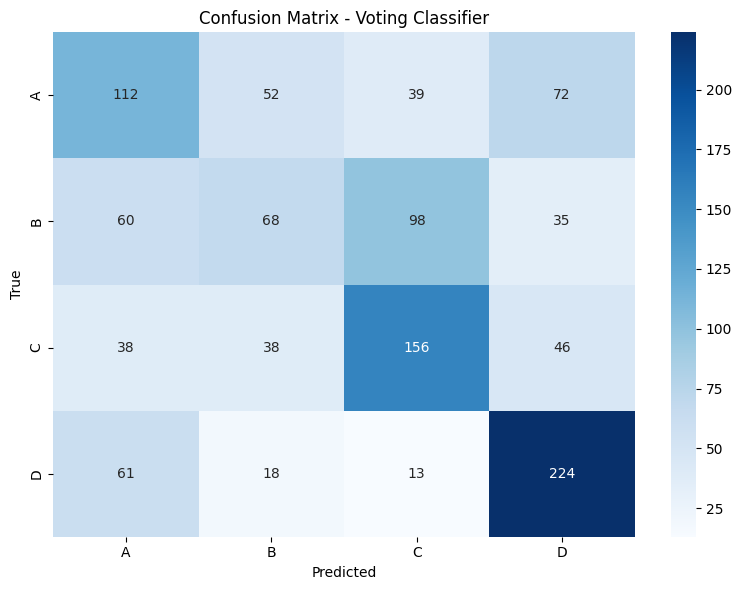

In [47]:

# Define base classifiers for voting
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf3 = LogisticRegression(max_iter=1000, random_state=42)

# Create voting classifier
voting_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', VotingClassifier(estimators=[
        ('rf', clf1),
        ('gb', clf2),
        ('lr', clf3)
    ], voting='soft'))
])

# Train the model
voting_clf.fit(X_train, y_train)

# Make predictions
voting_predictions = voting_clf.predict(X_val)

# Evaluate the model
voting_f1_macro = f1_score(y_val, voting_predictions, average='macro')
print(f"Voting Classifier - Macro F1 Score: {voting_f1_macro:.4f}")

# Display classification report
print("\nClassification Report (Voting Classifier):")
print(classification_report(y_val, voting_predictions))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, voting_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix - Voting Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

### 4.1.4 Stacking
Stacking is a technique that trains multiple different models, with each model being trained on the entire dataset. The final prediction is obtained through a meta-learner model that takes the predictions of the previous models as input. As a reference, you may use `StackingClassifier` to build your stacking model.


Stacking Classifier - Macro F1 Score: 0.4800

Classification Report (Stacking Classifier):
              precision    recall  f1-score   support

           A       0.39      0.41      0.40       275
           B       0.38      0.23      0.28       261
           C       0.54      0.59      0.57       278
           D       0.61      0.73      0.66       316

    accuracy                           0.50      1130
   macro avg       0.48      0.49      0.48      1130
weighted avg       0.49      0.50      0.49      1130



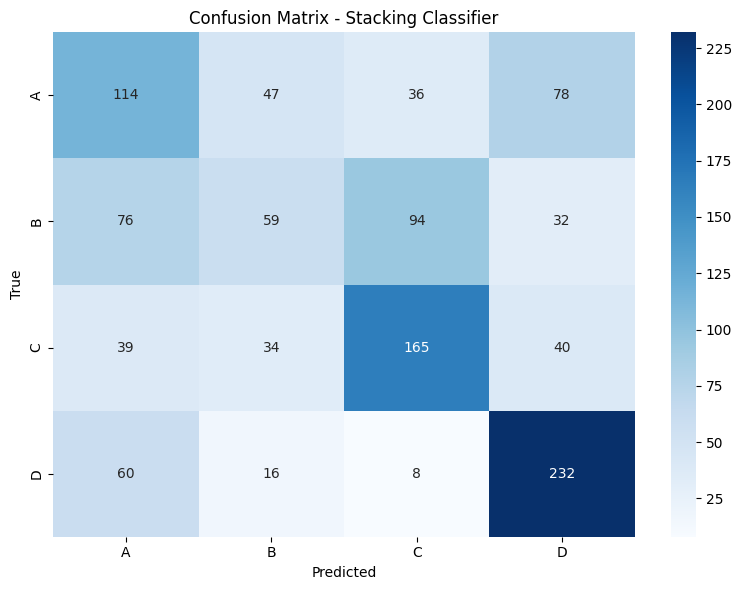

In [48]:

# Define base estimators for stacking
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)) 
]

# Create stacking classifier with logistic regression as final estimator
stacking_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=1000, random_state=42),
        cv=5
    ))
])

# Train the model
stacking_clf.fit(X_train, y_train_encoded)

# Make predictions
stacking_predictions = stacking_clf.predict(X_val)

# Decode predictions back to original labels (A, B, C, D)
stacking_predictions_decoded = label_encoder.inverse_transform(stacking_predictions)

# Evaluate the model
stacking_f1_macro = f1_score(y_val, stacking_predictions_decoded, average='macro')
print(f"Stacking Classifier - Macro F1 Score: {stacking_f1_macro:.4f}")

# Display classification report
print("\nClassification Report (Stacking Classifier):")
print(classification_report(y_val, stacking_predictions_decoded))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, stacking_predictions_decoded)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix - Stacking Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


Note: You can use/add other classifiers that haven't been mentioned, as long as it belong to one of the ensemble methods mentioned above.

## 4.2 Validation

Validation is the process of evaluating a trained model using a validation set or cross-validation method. It provides metrics that help determine the necessary steps for the next iteration of model development.  

For validation, the metric used is **log loss**, which measures the model's performance in terms of probabilistic predictions. A lower log loss indicates better model calibration.  

### Required Validation Results  
The validation results that must be included in the notebook are:  
1. The validation results from the required baseline models.  
2. The validation results from the final submission model on **Kaggle**.  

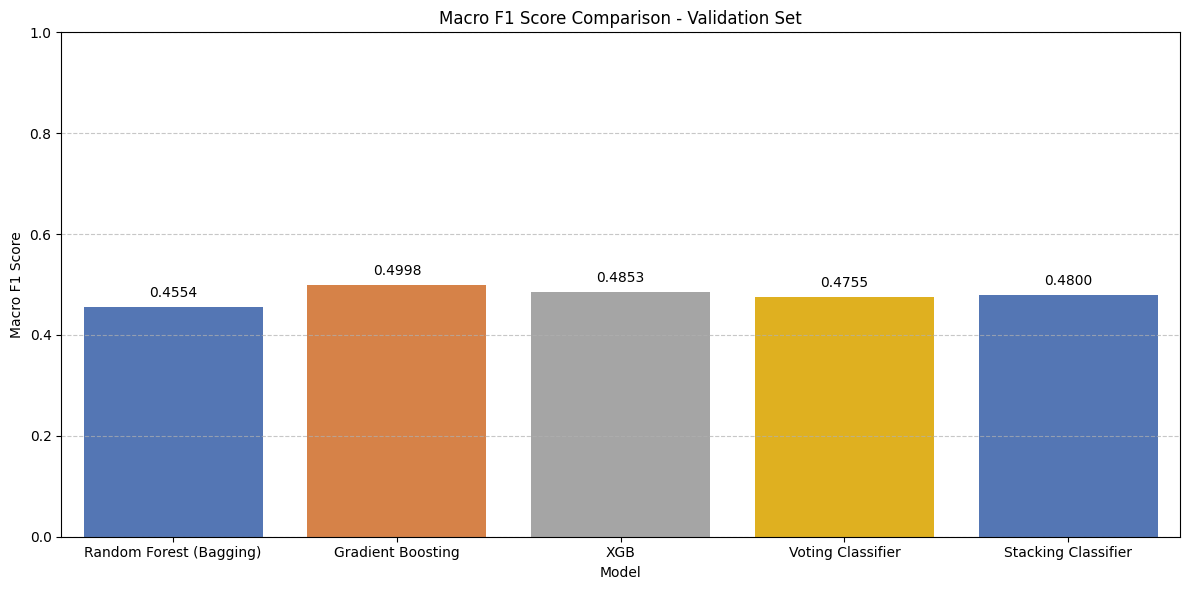

Best performing model: Gradient Boosting with macro F1 score of 0.4998


In [49]:
models = {
    'Random Forest (Bagging)': rf_f1_macro,
    'Gradient Boosting': gb_f1_macro,
    'XGB' : xgb_f1_macro,
    'Voting Classifier': voting_f1_macro,
    'Stacking Classifier': stacking_f1_macro
}

# Plot comparison
plt.figure(figsize=(12, 6))
model_names = list(models.keys())
model_scores = list(models.values())
colors = ['#4472C4', '#ED7D31', '#A5A5A5', '#FFC000']
sns.barplot(x=model_names, y=model_scores, palette=colors)
plt.title('Macro F1 Score Comparison - Validation Set')
plt.xlabel('Model')
plt.ylabel('Macro F1 Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

for i, score in enumerate(model_scores):
    plt.text(i, score + 0.02, f"{score:.4f}", ha='center')

plt.show()

# Find the best model
best_model_name = max(models, key=models.get)
best_score = models[best_model_name]
print(f"Best performing model: {best_model_name} with macro F1 score of {best_score:.4f}")


## Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set
5. Make sure the submission contains the `ID`, `Segmentation` column.

In [50]:
best_model = stacking_clf

# Retrain the best model on the full training dataset
best_model.fit(original_X, original_y)

# Make predictions on the test dataset
test_predictions = best_model.predict(test_df)

# Create submission dataframe
submission_df = pd.DataFrame({
    'ID': test_df['ID'],
    'Segmentation': test_predictions
})

# Export to CSV
submission_df.to_csv('output/submission.csv', index=False)
print("Submission file created successfully.")


Submission file created successfully.


# 5. Error Analysis

Based on all the process you have done until the modeling and evaluation step, write an analysis to support each steps you have taken to solve this problem. Write the analysis using the markdown block. Some questions that may help you in writing the analysis:

1. Which segments (A, B, C, D) have the highest and lowest misclassification rates?
2. Are there any specific segments where the model struggles to make correct predictions?
3. Which features contribute the most to incorrect predictions?
4. Which ensemble technique (Bagging, Boosting, Stacking, Voting) produces the lowest log loss?
5. Are there significant differences in error distribution between different ensemble models?
6. Does a particular model consistently misclassify certain segments more than others?
7. etc..

`Provide your analysis here`